In [5]:
# Imports 
import os
import xml.etree.ElementTree as et
import pandas as pd
from itertools import chain

import numpy as np
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD as LSA
import random
random.seed(13)


#visualisation stuff
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline

import spacy
from collections import Counter
from spacy.tokenizer import Tokenizer
nlp = spacy.load('en')
tokenizer = Tokenizer(nlp.vocab)

In [2]:
# Load data 
PATH = "../xml/"
extension = ".xml"

def load_order(PATH, extension):
    """
    Custom function for loading and sorting the xml files from the TOTA dataset.
    Returns an array of filenames sorted by the number in the file name.
    """
    files = []
    for filename in os.listdir(PATH):
        if filename == ".ipynb_checkpoints":
            continue
        files.append(filename.split(".")[0]) # remove .xml
    files.sort(key=lambda x:int(x.split("_")[1])) # sort files based on file number 

    files = [file + extension for file in files]
#     print(files)
    return files

files = load_order(PATH, extension)

In [3]:
def xml2list(file):
    """
    Custom function for parsing and outputing the data into arrays.
    Returns two array's the extracted column names and content for each column.
    """
    parsed_xml = et.parse(file)

    root = parsed_xml.getroot()

    meta_column_names = []
    meta_column_content = []

    for item in root[0]:
        grandchild = item.findall(".//")
        if grandchild:
            grandstore = []
            #print(item.tag)
            meta_column_names.append(item.tag)
            for x in grandchild:
                grandstore.append(int(x.attrib.get('n')))
                #print(x.tag +":", x.attrib)
            meta_column_content.append(grandstore)

        else:
            #print(item.tag +":", item.text)
            meta_column_names.append(item.tag)
            meta_column_content.append(item.text)
            
    return meta_column_names, meta_column_content
    
    
def xml2list_text(file):
    """
    Custom function for parsing and outputing the data into arrays.
    Returns two array's the extracted column names and content for each column.
    """

    parsed_xml = et.parse(file)
    root = parsed_xml.getroot()
    chapters = []
    article_store = []
    
    treaty_text = ''
    
    for item in root[1]:
        chapter_name = item.attrib.get('name')
#         print("chapter: " + item.attrib.get('name'))
        chapters.append(chapter_name)
        if chapter_name == None:
            continue
        treaty_text += chapter_name + " "
        
        articles = item.findall("article")
        for article in articles:
#             print(article.attrib.get('name'))
            art_no = article.attrib.get('number')
            art_text =  article.text
            article_store.append(art_no)
            if art_no == None:
                continue
#             print(art_no)
            treaty_text += art_no + " "
            treaty_text += art_text + " "
        
            
    return len(chapters), len(article_store), treaty_text

In [4]:
textdf = pd.DataFrame()

chapter_numbers = []
article_numbers = []
treaty_text = []

for i in range(0, len(files)):
    chapter_no, article_no, text = xml2list_text(PATH + files[i])
    chapter_numbers.append(chapter_no)
    article_numbers.append(article_no)
    treaty_text.append(text.lower())

textdf["chapter_number"] = chapter_numbers
textdf["article_number"] = article_numbers
textdf["treaty_text"] = treaty_text

In [7]:
with open("alltext.txt") as f:
    wordcount = Counter(f.read().split())

stop_words_law = []
for item, frequency in wordcount.most_common(2000):
    stop_words_law.append(item)
stop_words_law.append('\n')

In [8]:
dfcols, null = xml2list(PATH + files[3])
totadf = pd.DataFrame(columns=dfcols)

for i in range(0, len(files)):
    dfcolstmp, datatmp = xml2list(PATH + files[i])
    tmp_df = pd.DataFrame([datatmp], columns=dfcolstmp)
    tmp_df = tmp_df.loc[:,~tmp_df.columns.duplicated()] #very important! removes duplicate columns note that it removes the multiple "source" columnsns
    totadf = totadf.loc[:,~totadf.columns.duplicated()]#very important! removes duplicate columns note that it removes the multiple "source" columnsns 
    totadf = pd.concat([totadf,tmp_df], axis=0, sort=False)
totadf = totadf.reset_index(drop=True)
totadf = pd.concat([totadf, textdf], axis=1)

In [120]:
totadf['year_signed'] = totadf.date_signed.map( lambda x: pd.to_datetime(x).year)
totadf = totadf[totadf.language == 'en']
new = ['treaty_identifier', 'chapter_number', 'article_number', 'treaty_text', 'year_signed', 'region']

totadf_emb = totadf[new]
totadf_emb = totadf_emb.reset_index()
totadf_emb.head()

,index,treaty_identifier,chapter_number,article_number,treaty_text,year_signed,region
0,0,1,17,175,preamble general provisions article 1 the obje...,2007,East Asia
1,1,2,8,40,preamble article 1 the parties shall gradually...,2005,Africa; Europe
2,2,3,21,201,preamble general provisions article 1 the part...,2007,South America; East Asia
3,3,4,3,0,,2006,Europe; Commonwealth of Independent States (CIS)
4,4,5,11,52,preamble general provisions article 1 1. egypt...,2007,Africa; Europe


In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [115]:
n_features = 1000
n_topics = 7 # 5 because I want it to try and cluster based on the 5 treaty types
n_top_words = 3

#I convert a collection of raw documents into a matrix of TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=n_features, stop_words=stop_words_law)
#retearns a term-document matrix
tfidf = tfidf_vectorizer.fit_transform(totadf_emb['treaty_text'])
# This is where the non negative matrix factorization happens - in short it is a form of dimensionality reduction
nmf = LSA(n_components=n_topics, n_iter=5, random_state=0).fit(tfidf)

nmf_embedding = nmf.transform(tfidf)
nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)


topics = list(range(n_topics)) #these are hand coded topics and probably do not represent the actual topics 

tsne = TSNE(n_components=2,n_iter=5000, random_state=3211,learning_rate=50, perplexity=5) # run t-sne with the various parameters
tsne_embedding = tsne.fit_transform(nmf_embedding) 
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y']) # turn the results into a dataframe
tsne_embedding['hue'] = nmf_embedding.argmax(axis=1) # attach a hue column so that we can later color each cluster differently
tsne_embedding['year'] = totadf['year_signed'] # attach a year column so that we can see the evolution of the treaties over time.
tsne_embedding['type'] = totadf['type']

tsne_embedding.head()

,x,y,hue,year,type
0,-13.403955,-32.524448,1,2007.0,Free Trade Agreement & Economic Integration Ag...
1,14.256178,51.378994,0,2005.0,Free Trade Agreement
2,-13.379213,-39.162933,1,2007.0,Free Trade Agreement & Economic Integration Ag...
3,57.472298,-40.947681,1,2006.0,Free Trade Agreement
4,-23.485853,14.629520,4,2007.0,Free Trade Agreement


In [116]:
years = list(totadf_emb.year_signed.unique())
years.sort()

In [117]:
def year_average(tsne_embedding, years, n_topics):
    """
    Returns dataframe with average vector positions for each cluster on a yearly basis
    """
    average_time = []
    average_hue = []
    year = []
    types = []
    hues = list(range(0, n_topics))
    for index in range(0, len(years)):
        for hue in hues:
            if len(tsne_embedding[(tsne_embedding['year'] == years[index])& (tsne_embedding['hue'] == hue)].x.values) < 1:
                average_time.append(tsne_embedding[(tsne_embedding['year'] == years[index - 1])& (tsne_embedding['hue'] == hue)][['x', 'y']].mean())
                agree_type = tsne_embedding[(tsne_embedding['year'] == years[index - 1])& (tsne_embedding['hue'] == hue)].type
                if len(agree_type.values) > 0:
                    types.append(agree_type.values[0])
                else:
                    types.append(None)   
            
            else:
                average_time.append(tsne_embedding[(tsne_embedding['year'] == years[index])& (tsne_embedding['hue'] == hue)][['x', 'y']].mean())
                agree_type = tsne_embedding[(tsne_embedding['year'] == years[index])& (tsne_embedding['hue'] == hue)].type
                types.append(agree_type.values[0])
#                 print(agree_type.values[0])

            average_hue.append(hue)
            year.append(years[index])
    over_time = pd.DataFrame(average_time,columns=['x','y', 'hue', 'year'])
    over_time['hue'] = average_hue
    over_time['year'] = year
    over_time['type'] = types
    return over_time
over_time = year_average(tsne_embedding, years, n_topics)

In [118]:
over_time.head()

,x,y,hue,year,type
0,NaN,NaN,0,1948,None
1,NaN,NaN,1,1948,None
2,NaN,NaN,2,1948,None
3,-78.096382,9.418410,3,1948,Customs Union
4,5.383552,52.266331,4,1948,Free Trade Agreement


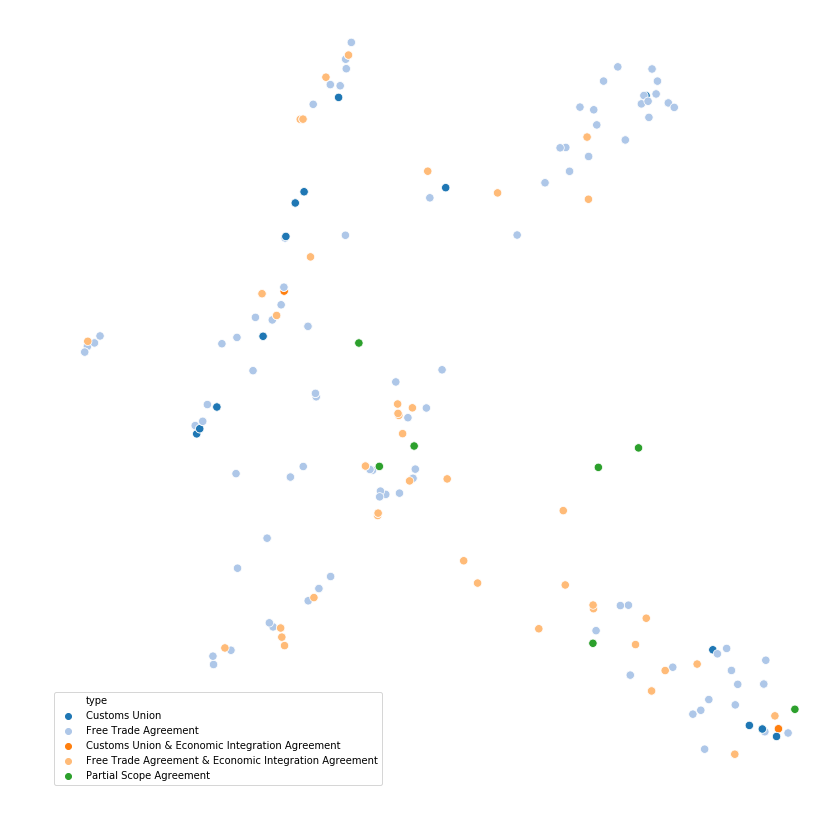

In [119]:
# color_list = plt.cm.tab20(np.linspace(0, 1, n_topics))

fig, axs = plt.subplots(figsize=(14, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0)

for year, idx in zip([2016], range(1)):
    data = over_time[(over_time['year']<=year)]
    over_time.to_csv("year.csv", sep=",")
    ax = sns.scatterplot(data=data, x='x',y='y', hue='type', palette='tab20', s=70)

#     axs.set_title('Treaties signed until {}'.format(year),**{'fontsize':'10'})
    axs.axis('off')

# fig.legend(legend_list, topics, loc=(0.2,0.89), ncol=5)
# plt.plot(x=data['x'],y=data['y',s=9,c=data['hue'], cmap='viridis', linestyle='-', marker='o')
plt.subplots_adjust(top=0.85)
plt.show()